<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>XGBoost model demo</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
</table>

This notebook walks you through these steps:
 
- Access the data
- Cleanse data for analysis
- Explore data
- Build a classification model



### Step 1: Download Data as a Pandas Dataframe 

Read the three Mortgage files from Local file storage - Insert them as PANDAS Dataframes

In [7]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_1e498447d5f74cd6b90b92b35bb6514e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='VYkxc-7ohgrp0zdnHRSHAQW-aqI5m-b6j8K3YBllfR4a',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_1e498447d5f74cd6b90b92b35bb6514e.get_object(Bucket='datascienceinbanking-donotdelete-pr-hrnb5icgks2da6',Key='Mortgage_Training Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

customerData = pd.read_csv(body)
customerData.head()

,ID,Income,AppliedOnline,Residence,YearCurrentAddress,YearsCurrentEmployer,NumberOfCards,CCDebt,Loans,LoanAmount,SalePrice,Location,MortgageDefault
0,100522.0,43982.0,YES,Owner Occupier,13.0,11.0,2.0,1055.0,0.0,9405.0,500000,110,NO
1,101756.0,59944.0,YES,Owner Occupier,20.0,11.0,2.0,3894.0,0.0,9880.0,750000,110,NO
2,101354.0,57718.0,YES,Owner Occupier,25.0,16.0,2.0,1555.0,1.0,6285.0,155000,130,YES
3,100512.0,45621.0,YES,Owner Occupier,1.0,19.0,1.0,1878.0,0.0,9260.0,195000,100,YES
4,100537.0,45081.0,NO,Owner Occupier,14.0,15.0,2.0,713.0,1.0,8430.0,140000,110,NO


### Step 2: Simple Data Preparation - Rename some columns and ensure correct data types 
This step is to remove spaces from columns names

In [8]:
customerData = customerData.rename(index=str, columns={"Yrs at Current Address":"YearCurrentAddress", "Yrs with Current Employer":"YearsCurrentEmployer",\
                      "Number of Cards":"NumberOfCards","Creditcard Debt":"CCDebt","Loan Amount":"LoanAmount"})
customerData.head(3)

,ID,Income,AppliedOnline,Residence,YearCurrentAddress,YearsCurrentEmployer,NumberOfCards,CCDebt,Loans,LoanAmount,SalePrice,Location,MortgageDefault
0,100522.0,43982.0,YES,Owner Occupier,13.0,11.0,2.0,1055.0,0.0,9405.0,500000,110,NO
1,101756.0,59944.0,YES,Owner Occupier,20.0,11.0,2.0,3894.0,0.0,9880.0,750000,110,NO
2,101354.0,57718.0,YES,Owner Occupier,25.0,16.0,2.0,1555.0,1.0,6285.0,155000,130,YES


Check data types and re-cast numeric fields to **Integers**

In [9]:
customerData.dtypes

ID                      float64
Income                  float64
AppliedOnline            object
Residence                object
YearCurrentAddress      float64
YearsCurrentEmployer    float64
NumberOfCards           float64
CCDebt                  float64
Loans                   float64
LoanAmount              float64
SalePrice                 int64
Location                  int64
MortgageDefault          object
dtype: object

In [10]:
customerData[['ID','Income','YearCurrentAddress','YearsCurrentEmployer','NumberOfCards','CCDebt','Loans','LoanAmount']] = \
customerData[['ID','Income','YearCurrentAddress','YearsCurrentEmployer','NumberOfCards','CCDebt','Loans','LoanAmount']].astype(int)
customerData.dtypes

ID                       int64
Income                   int64
AppliedOnline           object
Residence               object
YearCurrentAddress       int64
YearsCurrentEmployer     int64
NumberOfCards            int64
CCDebt                   int64
Loans                    int64
LoanAmount               int64
SalePrice                int64
Location                 int64
MortgageDefault         object
dtype: object

### Step 4: Data Exploration

1) Obtain some data shape summaries in terms of number of fields and records <br>
2) Perform some exploratory analysis of distributions, scatterplots using two different graphics packages


In [11]:
print ("There are " + str(customerData.shape[0]) + " records and " + str(customerData.shape[1]) + " fields in the dataset.")

There are 419 records and 13 fields in the dataset.


In [12]:
import brunel
%brunel data('customerData') bar x(Residence) y(Income) mean(CCDebt) color(MortgageDefault) stack tooltip(Income) \
| x(YearCurrentAddress) y(YearsCurrentEmployer) point color(MortgageDefault) tooltip(YearCurrentAddress, YearsCurrentEmployer) \
:: width=1100, height=400 

<IPython.core.display.Javascript object>


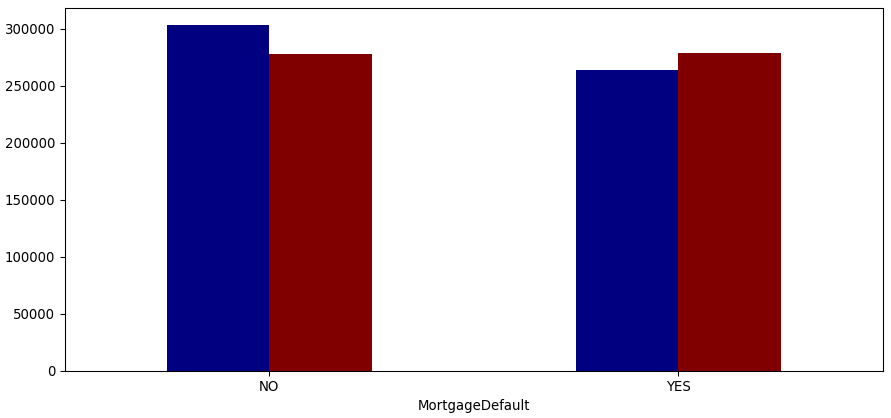

In [13]:
from pixiedust.display import *
display(customerData)

### Step 5: Build the XGBoost model

In recent years, ensemble learning models took the lead and became popular among machine learning practitioners.

Ensemble learning model employs multiple machine learning algorithms to overcome the potential weaknesses of a single model. For example, if you are going to pick a destination for your next vacation, you probably ask your family and friends, read reviews and blog posts. Based on all the information you have gathered, you make your final decision.

This phenomenon is referred as the Wisdom of Crowds (WOC) in social sciences and it states that averaging the answers (prediction or probability) of a group will often result better than the answer of one of its members. The idea is that the collective knowledge of diverse and independent individuals will exceed the knowledge of any one of those individuals, helping to eliminate the noise.

XGBoost is an open source library for ensemble based algorithms. It can be used for classification, regression and ranking type of problems. XGBoost supports multiple languages, such as C++, Python, R, and Java. 

The Python library of XGBoost supports the following API interfaces to train and predict a model, also referred to as a `Booster`: 
- XGBoost's native APIs pertaining to the `xgboost` package, such as `xgboost.train()` or `xgboost.Booster`
- Scikit-Learn based Wrapper APIs: `xgboost.sklearn.XGBClassifier` and `xgboost.sklearn.XGBRegressor`

Details about using the scikit-learn based Wrapper APIs to create and predict an XGBoost model is explained in the the [Classify tumors with machine learning](https://apsportal.ibm.com/exchange/public/entry/view/ac820b22cc976f5cf6487260f4c8d9c8) notebook.

In this section you will learn how to train and test an XGBoost model using XGBoost's native python APIs. 

First, you must import the required libraries.

In [14]:
import xgboost as xgb

import pandas as pd

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from matplotlib import pyplot
import pprint
%matplotlib inline
import numpy as np


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 5.1: Prepare data

In this section, clean and transform the data in the Pandas data frame into the data that can be given as input for training the model. 

In [15]:
print("List of features with their corresponding count of null values : ")
print("---------------------------------------------------------------- ")
print(customerData.isnull().sum())

List of features with their corresponding count of null values : 
---------------------------------------------------------------- 
ID                      0
Income                  0
AppliedOnline           0
Residence               0
YearCurrentAddress      0
YearsCurrentEmployer    0
NumberOfCards           0
CCDebt                  0
Loans                   0
LoanAmount              0
SalePrice               0
Location                0
MortgageDefault         0
dtype: int64


#### 5.1.2: Prepare the target data and feature columns

In this section, transform the existing data frame to derive the target data that contains the prediction value for the corresponding sample data. 

The goal of the model here is to predict whether a mortgage customer will default on their loan. The column Mortgage Default is currently a VarChar with values YES/NO and therefore it needs to be converted to a numeric

In [16]:
# Convert the VarChar columns to numeric columns

le = LabelEncoder()
customerData.loc[:,'MortgageDefault']= le.fit_transform(customerData.loc[:,'MortgageDefault'])
customerData.head()

,ID,Income,AppliedOnline,Residence,YearCurrentAddress,YearsCurrentEmployer,NumberOfCards,CCDebt,Loans,LoanAmount,SalePrice,Location,MortgageDefault
0,100522,43982,YES,Owner Occupier,13,11,2,1055,0,9405,500000,110,0
1,101756,59944,YES,Owner Occupier,20,11,2,3894,0,9880,750000,110,0
2,101354,57718,YES,Owner Occupier,25,16,2,1555,1,6285,155000,130,1
3,100512,45621,YES,Owner Occupier,1,19,1,1878,0,9260,195000,100,1
4,100537,45081,NO,Owner Occupier,14,15,2,713,1,8430,140000,110,0


In [17]:
# Check the values for MortgageDefault

customerData.groupby(['MortgageDefault']).size()

MortgageDefault
0    239
1    180
dtype: int64

In [20]:
# Only need to run this once within your notebook
!pip install sklearn-pandas

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
mxnet 1.5.0 requires graphviz<0.9.0,>=0.8.1, which is not installed.
mxnet 1.5.0 has requirement numpy<2.0.0,>1.16.0, but you'll have numpy 1.13.3 which is incompatible.
mxnet 1.5.0 has requirement requests<3,>=2.20.0, but you'll have requests 2.18.4 which is incompatible.


In [21]:
!pip install mxnet --no-deps

In [22]:
# Apply the LabelEncoder to encode the input features in numeric form where applicable
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([
     ('Income', None),
     ('AppliedOnline', LabelEncoder()),
     ('Residence', LabelEncoder()),
     ('YearCurrentAddress',None),
     ('YearsCurrentEmployer',None),
     ('NumberOfCards',None),
     ('CCDebt',None),
     ('Loans',None),
     ('LoanAmount',None),
     ('SalePrice',None),
     ('Location',None)
    ])

In [23]:
# Drop the Varchar fields from the analysis
feature_cols = ['Income','YearCurrentAddress','YearsCurrentEmployer','NumberOfCards','CCDebt','Loans','LoanAmount','SalePrice','Location']
features_df = customerData[feature_cols]
features_df.head()

,Income,YearCurrentAddress,YearsCurrentEmployer,NumberOfCards,CCDebt,Loans,LoanAmount,SalePrice,Location
0,43982,13,11,2,1055,0,9405,500000,110
1,59944,20,11,2,3894,0,9880,750000,110
2,57718,25,16,2,1555,1,6285,155000,130
3,45621,1,19,1,1878,0,9260,195000,100
4,45081,14,15,2,713,1,8430,140000,110


#### 5.1.3: Split the data set for training and testing

As the target and feature columns has been defined, you can now split the data set into two sets that will be used for training the model and for testing the trained model. 

In [24]:
# define the label (Target Field) and features
# split the data to training and testing set
y = np.float32(customerData.MortgageDefault)
x = features_df
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

#### 5.1.4: Construct DMatix objects 

DMatrix is the data interface provided by the XGBoost library. The training data and test data are converted as DMatrix objects to perform training and to make predictions. The DMatrix objects can be created from various data formats, such as Numpy arrays, Pandas data frames, or a Scipy sparse array. For more information about the DMatrix interface, see [Python Package Introduction](http://xgboost.readthedocs.io/en/latest/python/python_intro.html).

In [25]:
# Prepare the **DMatrix** objects for training and testing based on the training and test data that was split above
dm_train = xgb.DMatrix(x_train, label=y_train)
dm_test = xgb.DMatrix(x_test)

### 5.2: Create XGBoost model (Booster)

In [26]:
# Set the parameters of the Booster that we are about to create and train.

param = {'objective':'multi:softmax', 'max_depth':2, 'eta':0.8, 'num_class': 2, 'eval_metric': 'auc', 'silent':1 }

In [27]:
# Create a Booster by using the training data set, which is in the form of a DMatrix object.

xgb_model = xgb.train(param, dm_train)

### Step 6: Model Evaluation 

In [28]:
# call xgb_model.predict() on your matrix test data to make a set of test predictions which are written to series y_predict

y_predict = xgb_model.predict(dm_test)
print(y_predict)


[ 1.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  1.
  1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  0.  0.  1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.  1.
  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.
  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  1.  0.]


In [29]:
# Look at the accuracy of the XGBoost model
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy: " +  str(accuracy))


Accuracy: 0.666666666667


### Step 7: Understanding the XGBoost Model

#### 7.1: View the scored "Test" data

In [30]:
#Reset the index on the x_train data so that the join will match record by record and not require a key
x_test.reset_index(drop=True, inplace=True)

#Write the Actual and Predicted Mortgage Default values in to dataframes 
y_test_df = pd.DataFrame(y_test,columns=['MortgageDefault'])
y_pred_df = pd.DataFrame(y_predict,columns=['Pred Default'])

# Combine the three dataframes by index value rather than key field
scored_df = pd.concat([x_test, y_test_df, y_pred_df], axis=1)
scored_df.head()


,Income,YearCurrentAddress,YearsCurrentEmployer,NumberOfCards,CCDebt,Loans,LoanAmount,SalePrice,Location,MortgageDefault,Pred Default
0,45246,6,5,1,737,1,5300,175000,130,1.0,1.0
1,43185,0,8,1,20,0,9420,305000,130,0.0,0.0
2,45659,12,17,1,9466,1,17050,340000,100,0.0,0.0
3,44483,16,15,2,116,0,7535,245000,130,1.0,1.0
4,45712,14,15,2,2216,0,8910,215000,100,0.0,0.0


#### 7.2: Model Interpretation

To understand the model better, XGBoost provides APIs that you can use to get insights about the trees used for training the model and the importance of the features in constructing the Booster.

In [31]:
# Import plot / graph libraries required for model interpretation
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


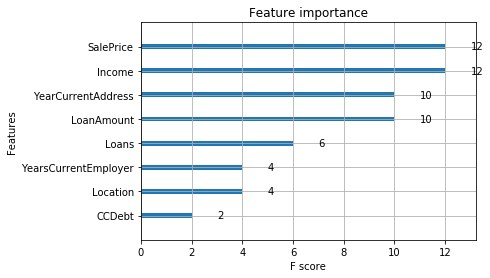

In [33]:
# Plot the feature importance
xgb.plot_importance(xgb_model)